In [ ]:
!pip install unidecode

In [ ]:
import unidecode
import string
import random
import re
import os

import torch
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
from google.colab import files
file_uploaded = files.upload()

file_uploaded = files.upload()

Saving lose_yourself_eminem.txt to lose_yourself_eminem (3).txt


In [ ]:
file = unidecode.unidecode(open('lose_yourself_eminem.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 4086


In [ ]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

e music
The moment, you own it, you better never let it go (Go)
You only get one shot, do not miss your chance to blow
This opportunity comes once in a lifetime, yo
You better lose yourself in the musi


In [ ]:
all_characters = string.printable
print(all_characters)

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print('abcDEF is changed to ', char_tensor('abcDEF'))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

abcDEF is changed to  tensor([10, 11, 12, 39, 40, 41])


In [ ]:
def random_training_set():
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:])
    return inputs, targets

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        self.encoder = nn.Embedding(input_dim, hidden_dim)

        # lstm
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.f_gate_x = nn.Linear(hidden_dim, hidden_dim)
        self.f_gate_h = nn.Linear(hidden_dim, hidden_dim)
        self.i_gate_x = nn.Linear(hidden_dim, hidden_dim)
        self.i_gate_h = nn.Linear(hidden_dim, hidden_dim)
        self.o_gate_x = nn.Linear(hidden_dim, hidden_dim)
        self.o_gate_h = nn.Linear(hidden_dim, hidden_dim)
        self.c_state_x = nn.Linear(hidden_dim, hidden_dim)
        self.c_state_h = nn.Linear(hidden_dim, hidden_dim)

        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hn, cn):
        input = self.encoder(input.view(1, -1))

        # lstm
        input = input.view(1, 1, -1)
        for t in range(input.size()[1]):
            f = self.sig(self.f_gate_x(input[:,t,:]) + self.f_gate_h(hn[0,:,:]))
            i = self.sig(self.i_gate_x(input[:,t,:]) + self.i_gate_h(hn[0,:,:]))
            o = self.sig(self.o_gate_x(input[:,t,:]) + self.o_gate_h(hn[0,:,:]))
            cb = self.tanh(self.c_state_x(input[:,t,:]) + self.c_state_h(hn[0,:,:]))

            cn = torch.mul(f, cn) + torch.mul(i, cb)
            hn = torch.mul(o, self.tanh(cn))
            output = hn

        output = self.decoder(output.view(1, -1))
        return output, hn, cn

    def init_hidden(self):
        h0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim).cuda())
        c0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim).cuda())
        return h0, c0

hidden_dim = 100
n_layers = 1
n_characters = len(all_characters)

model = LSTMModel(n_characters, hidden_dim, n_layers, n_characters)
model.cuda()

LSTMModel(
  (encoder): Embedding(100, 100)
  (sig): Sigmoid()
  (tanh): Tanh()
  (f_gate_x): Linear(in_features=100, out_features=100, bias=True)
  (f_gate_h): Linear(in_features=100, out_features=100, bias=True)
  (i_gate_x): Linear(in_features=100, out_features=100, bias=True)
  (i_gate_h): Linear(in_features=100, out_features=100, bias=True)
  (o_gate_x): Linear(in_features=100, out_features=100, bias=True)
  (o_gate_h): Linear(in_features=100, out_features=100, bias=True)
  (c_state_x): Linear(in_features=100, out_features=100, bias=True)
  (c_state_h): Linear(in_features=100, out_features=100, bias=True)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

lr = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
def evaluate(prime_str='W', predict_len=100):
    # suppose prims_str is a single character
    # and use greedy search to predict the next character

    hn, cn = model.init_hidden()
    predicted = str()

    for i in range(predict_len):
        if i == 0:
            char = prime_str

        out, hn, cn = model(char_tensor(char).cuda(), hn, cn)

        highest_out = torch.argmax(out)
        char = all_characters[highest_out]

        predicted += char

    return predicted

************************* epoch100 *************************
loss 388.0764
s on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on on 

************************* epoch200 *************************
loss 413.8141
 the mometter so lose the mometter so lose the mometter so lose the mometter so lose the mometter so 

************************* epoch300 *************************
loss 258.9594
 goes opportunity comes on the moment, you better lose it one so lose it only get on the moment, you 

************************* epoch400 *************************
loss 195.7664
 whe moment, you better lose in the moment, you better lose in the moment, you better lose in the mo 

************************* epoch500 *************************
loss 173.1729
 wand the moment, you own it only get one shot, you own it only get one shot, you own it only get on 

************************* epoch600 *************************
loss 200.1038
 call on his momin' once in a lifet

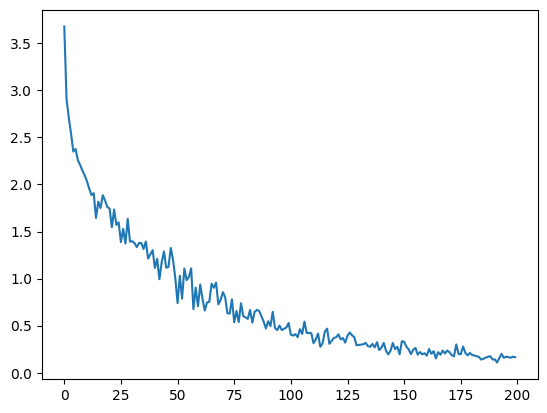

In [ ]:
n_epochs = 2000
print_every = 100
plot_every = 10

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    # Load text
    inputs, targets = random_training_set()
    if inputs.size()[0] < 200: continue

    # Clear gradients w.r.t. parameters
    model.zero_grad()
    optimizer.zero_grad()

    # Forward pass
    loss = 0
    hn, cn = model.init_hidden()
    for c in range(chunk_len):
        out, hn, cn = model(inputs[c].cuda(), hn, cn)
        loss += criterion(out, targets[c].unsqueeze(0).cuda())

    # Backward pass
    loss.backward()

    # Updating parameters
    optimizer.step()

    loss_avg += loss.item() / chunk_len

    if epoch % print_every == 0:
        print('*'*25, 'epoch%d'%epoch, '*'*25)
        print('loss %.4f'%loss.item())
        print(evaluate('I', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

#################################################
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(all_losses)

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)